# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [15]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import matplotlib.dates as dates

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [12]:
def data():
    
    """ reads in the data file, creates DayOfYear, Year and Temperature columns
    """
    
    # read the data
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
    
    # Convert Date column to date data type
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    
    # Create DayOfYear and year columns
    df['DayOfYear'] = df['Date'].dt.strftime('%m/%d')
    df['Year'] = df['Date'].dt.year
    
    # Get rid of February 29th dates
    df = df[df.DayOfYear != '02/29']
    
    # Readd all dates.  All will have year 1900, and this doesn't matter since year was extracted
    df['DayOfYear'] = pd.to_datetime(df['DayOfYear'], format='%m/%d')
    
    # Sort by the Date column
    df = df.sort_values('Date')
    
    # Get temperature in Deg C
    df['Temperature'] = df['Data_Value']/10.0
    
    # Drop the Data_Value and Date columns
    for col in ['Data_Value', 'Date']:
        df = df.drop(col, axis=1)
    
    return df

In [17]:
def get_highs_lows_pre_2015():
    
    """
    Get the record highs and lows for years before 2015 and return a Data Frame
    """
    
    # Remove data from before 2015
    df = data()
    df = df[df.Year < 2015]
    
    # Get the max and min based on DayOfYear
    result = df.groupby('DayOfYear')['Temperature'].agg(['max', 'min']).reset_index()
    
    # Create float representation of DayOfYear
    result['fds'] = result['DayOfYear'].apply(lambda x: dates.date2num(x))
    
    return result

In [19]:
def get_highs_lows_2015():
    
    """
    Get the record highs and lows that occurred in 2015
    """
    
    pre2015 = get_highs_lows_pre_2015()
    df = data()
    df = df[df.Year == 2015]
        
    # Get the max and min based on DayOfYear in 2015
    df2015 = df.groupby('DayOfYear')['Temperature'].agg(['max', 'min']).rename(columns={'max': 'max2015', 'min': 'min2015'}).reset_index()
    
    # Merge the pre2015 and 2015 DataFrames
    result = pd.merge(pre2015, df2015, how='outer', left_on='DayOfYear', right_on='DayOfYear')
    
    # Determine if min or max is more extreme than pre2015
    result['min_record_in_2015'] = result['min2015'] < result['min']
    result['max_record_in_2015'] = result['max2015'] > result['max']
    
    # Remove the rows with both values False
    result = result[(result.min_record_in_2015 == True) | (result.max_record_in_2015 == True)]
    
    return result

<IPython.core.display.Javascript object>


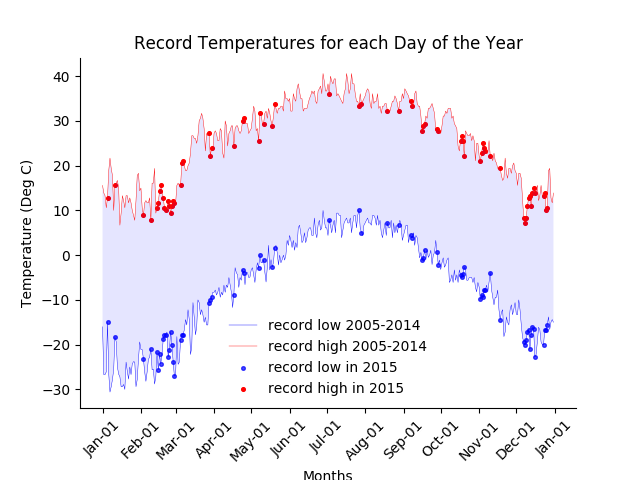

In [47]:
%matplotlib notebook

# Create new figure
plt.figure()

# Plot the record low and high from 2005-2014
pre2015 = get_highs_lows_pre_2015()
plt.plot(pre2015['fds'], pre2015['min'], c='blue', lw=0.3, label='record low 2005-2014')
plt.plot(pre2015['fds'], pre2015['max'], c='red', lw=0.3, label='record high 2005-2014')

# Plot the scatter points of records broken in 2015
df2015 = get_highs_lows_2015()
plt.scatter(df2015['fds'], df2015['min'], c='blue', marker='o', s=7, label='record low in 2015', alpha = 0.7)
plt.scatter(df2015['fds'], df2015['max'], c='red', marker='o', s=7, label='record high in 2015')

ax = plt.gca()

# Set date axis format
ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%d'))
ax.xaxis.set_major_locator(dates.MonthLocator())
loc, labels = plt.xticks()
plt.setp(labels, rotation=45)

# Make the x-axis go through y=0 and remove right and top spines
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a plot title and legend
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.subplots_adjust(bottom=0.15)
plt.legend(loc='best', frameon=False)
plt.ylabel('Temperature (Deg C)')
plt.title('Record Temperatures for each Day of the Year')
plt.xlabel('Months')

# fill the area between the record low and highs from 2005-2014
plt.gca().fill_between(pre2015['fds'], 
                       pre2015['min'], pre2015['max'], 
                       facecolor='blue', 
                       alpha=0.1)

# Show the plot
plt.show()